In [62]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [63]:
# 데이터 원본 파일 불러오기
dataset = pd.read_csv('data/Churn.csv')
dataset.shape

(10000, 14)

## Feature 해석하기

- 전부 결측값이 없음을 알 수 있다.

### 범주형 데이터
1. 명목형 피처 : Geography
    - Geography는 3종류 지역임을 알 수 있으며 object 타입으로 되어있다.
        - 인코딩이 필요하다.
    - 이진 피처 : Gender, HasCrCard, IsActiveMember, **Exited(target)**
        - 고윳값이 모두 2개이다.
        - Gender는 object 타입으로 되어 있지만 나머지는 int 타입으로 되어있다.
            - 인코딩이 필요하다
2. 순서형 피처 : 없음


### 수치형 데이터
1. 이산형 데이터 : NumOfProducts
    - 고윳값이 4개이다.
    - int 타입으로 되어 있다.
2. 연속형 데이터 : CreditScore, Age, Balance, EstimatedSalary
    - 고윳값이 다 다르지만 EstimatedSalary는 하나만 중복되어 있다.
    - CreditScore, Age는 int 타입, Balance, EstimatedSalary는 float 타입으로 되어있다.

---

- 그 외 데이터 : RowNumber, CustomerId, Surname
    - 필요 없는 데이터 이므로 제거하겠다.

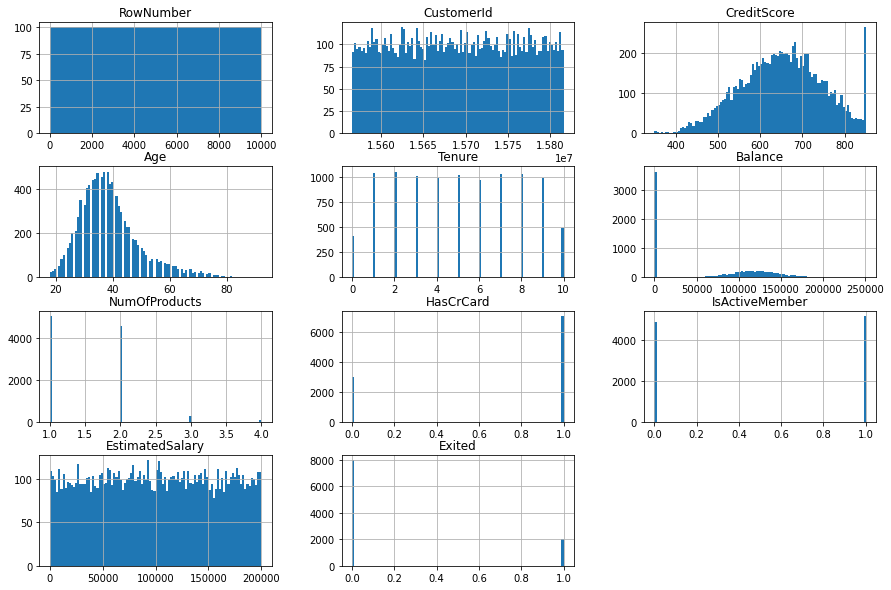

In [64]:
_ = dataset.hist(bins=100, figsize=(15, 10))

In [65]:
# feature 요약표
def resumetable(df):
    print(f'데이터셋 형상 : {df.shape}')
    summary =pd.DataFrame(df.dtypes, columns=['dtype'])\
                .reset_index().rename(columns={'index' : 'feature'})
    
    summary['null'] = df.isnull().sum().values # 결측값 개수
    summary['nunique'] = df.nunique().values # 고윳값 개수
    
    return summary

resumetable(dataset)

데이터셋 형상 : (10000, 14)


,feature,dtype,null,nunique
0,RowNumber,int64,0,10000
1,CustomerId,int64,0,10000
2,Surname,object,0,2932
3,CreditScore,int64,0,460
4,Geography,object,0,3
5,Gender,object,0,2
6,Age,int64,0,70
7,Tenure,int64,0,11
8,Balance,float64,0,6382
9,NumOfProducts,int64,0,4


In [66]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## target 분포

약 8 대 2 비율임을 알 수 있다.

In [67]:
dataset['Exited'].value_counts(normalize=True) * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

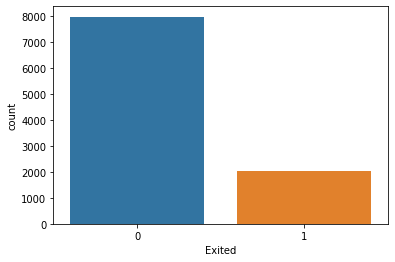

In [68]:
sns.countplot(x = 'Exited', data=dataset)
plt.show()

## Feature Engineering

In [69]:
# 필요 없는 피처 제거
drop_features = ['RowNumber', 'Surname', 'CustomerId']
dataset = dataset.drop(drop_features, axis=1)

In [70]:
# 원-핫 인코딩
ohe_features = ['Geography', 'Gender']

dataset = pd.get_dummies(dataset, columns=ohe_features)

dataset.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


# Baseline model

1. 환경 설정
    - 시드값 고정
    - target 지정
2. 데이터 준비
    - 훈련/학습 데이터 분리
3. 모델 구성
5. 성능 검증
6. 예측 및 제출

In [71]:
import tensorflow as tf

# 시드값 고정
seed = 42
# target 지정
label_name = 'Exited'

In [72]:
# train set, test set 나누기
train_dataset = dataset.sample(frac = 0.8, random_state = seed)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.shape, test_dataset.shape

((8000, 14), (2000, 14))

In [73]:
# target 나누기
train_labels = train_dataset.pop(label_name)
test_labels = test_dataset.pop(label_name)

train_labels.shape, test_labels.shape

((8000,), (2000,))

In [74]:
# input shape
input_shape = len(train_dataset.keys())

# 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=[input_shape]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                448       
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [75]:
# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# 모델 훈련
history = model.fit(train_dataset, train_labels, epochs=1000)

Epoch 1/100
250/250 - 0s - loss: 667.8825 - accuracy: 0.6800 - 430ms/epoch - 2ms/step
Epoch 2/100
250/250 - 0s - loss: 62.5145 - accuracy: 0.6896 - 163ms/epoch - 652us/step
Epoch 3/100
250/250 - 0s - loss: 65.2202 - accuracy: 0.6855 - 163ms/epoch - 653us/step
Epoch 4/100
250/250 - 0s - loss: 61.9068 - accuracy: 0.6886 - 164ms/epoch - 655us/step
Epoch 5/100
250/250 - 0s - loss: 67.5059 - accuracy: 0.6876 - 163ms/epoch - 653us/step
Epoch 6/100
250/250 - 0s - loss: 63.0329 - accuracy: 0.6910 - 164ms/epoch - 654us/step
Epoch 7/100
250/250 - 0s - loss: 60.1707 - accuracy: 0.6800 - 163ms/epoch - 654us/step
Epoch 8/100
250/250 - 0s - loss: 72.7232 - accuracy: 0.6798 - 165ms/epoch - 659us/step
Epoch 9/100
250/250 - 0s - loss: 59.4653 - accuracy: 0.6862 - 164ms/epoch - 655us/step
Epoch 10/100
250/250 - 0s - loss: 70.3739 - accuracy: 0.6799 - 163ms/epoch - 652us/step
Epoch 11/100
250/250 - 0s - loss: 73.6481 - accuracy: 0.6777 - 163ms/epoch - 651us/step
Epoch 12/100
250/250 - 0s - loss: 62.6577 

In [76]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,accuracy
95,16.372971,0.696875
96,17.084982,0.695250
97,12.945924,0.700750
98,13.733154,0.693375
99,16.814539,0.697750


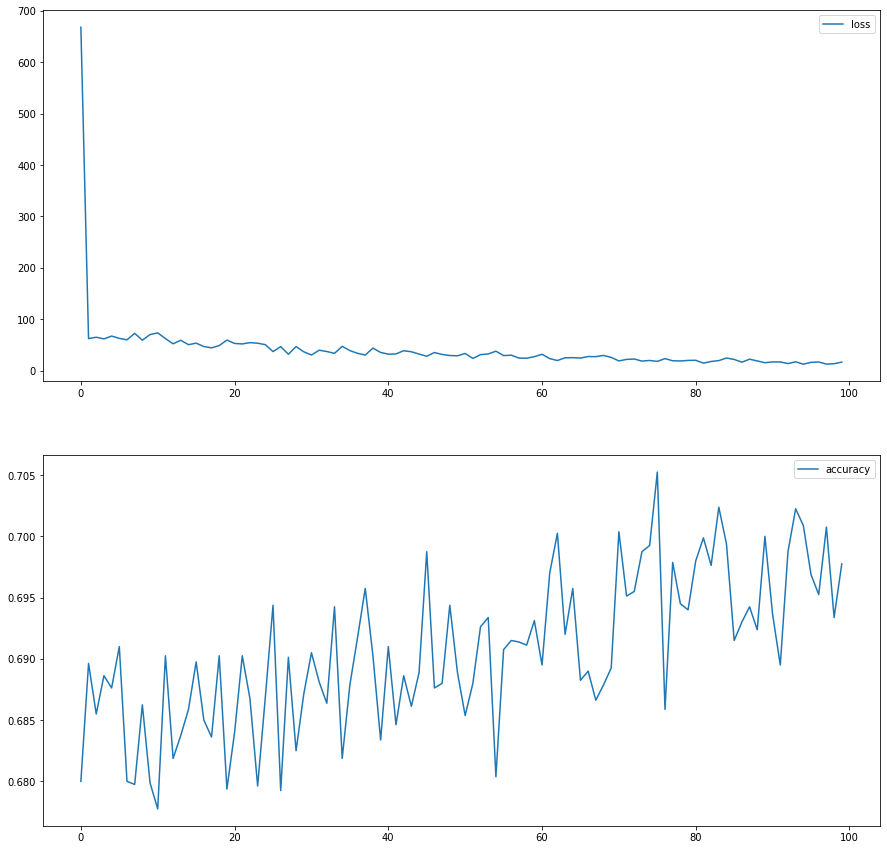

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
hist[['loss']].plot(ax=axes[0])
hist[['accuracy']].plot(ax=axes[1])
plt.show()

In [78]:
# 정확도 평가
test_loss, test_acc = model.evaluate(test_dataset, test_labels)

print('\nTest accuracy:', test_acc)

63/63 [==============================] - 0s 618us/step - loss: 10.8899 - accuracy: 0.7940

Test accuracy: 0.7940000295639038
